# ロジスティック回帰スクラッチ
ロジスティック回帰のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。<br>
<br>
以下に雛形を用意してあります。このScratchLogisticRegressionクラスにコードを書き加えていってください。推定関係のメソッドは線形回帰と異なり、ラベルを出力するpredictメソッドと、確率を出力するpredict_probaメソッドの2種類を作成します。

In [126]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [269]:
# 雛形

class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.num_iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.num_iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter=100, lr=0.1, C=1.0, bias=True,
                 verbose=False, coef=None, labels=None):
        # ハイパーパラメータを属性として記録
        self.num_iter = num_iter
        self.lr = lr
        self.C = C
        self.bias = bias
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.num_iter)
        self.val_loss = np.zeros(self.num_iter)
        self.coef_ = coef
        self.labels_ = labels
        
        
    def _logistic_hypothesis(self, X):
        """
        ロジスティック回帰の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            シグモイドの仮定関数による推定結果
        """

        return 1/(1 + np.exp(-1 * np.dot(X, self.coef_.T)))
    
    
    def _gradient_descent(self, X, y, h_array):
        """
        最急降下法によりパラメータの更新を行う

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        h_array : 次の形のndarray, shape (n_samples,)
            推定した値    

        Returns
        -------
        self.coef_ : 次の形のndarray, shape (n_features, 1)
            最急降下法により更新されたパラメータ
        """

        if self.bias:
            self.coef_[0] -= (self.lr/len(X)) * np.dot((h_array - y), X[:, 0])
            self.coef_[1:] -= (self.lr/len(X)) * np.dot((h_array - y), X[:, 1:]) + (1/self.C)/len(X) * self.coef_[1:]
        else:
            self.coef_ -= (self.lr/len(X)) * np.dot((h_array - y), X) + (1/self.C)/len(X) * self.coef_

        return self.coef_
    
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        
        # 目的変数のラベルを取得し、バイナリに変換した配列を作成
        # 以後、計算はy_indicesを用いて行う
        self.labels_, y_indices = np.unique(y, return_inverse=True)
        
        # bias有りの場合はX_0 = 1をXにinsertし、パラメータを作成
        if self.bias:
            X = np.insert(X, 0, 1, axis=1)
            self.coef_ = np.random.normal(size=len(X[0]))
        # bias無しの場合はX_0を追加せずパラメータを作成
        else:
            self.coef_ = np.random.normal(size=len(X[0]))

        # 検証データに対する学習の有無はX_valとy_valが提示された場合のみに指定
        # hasattr関数を使用し、X_val, y_valが__array__attributeを所持するかで判断
        if hasattr(X_val, '__array__') and hasattr(y_val, '__array__'):
            
            _, yval_indices = np.unique(y_val, return_inverse=True)
            
            for i in range(self.num_iter):
                
                h_array = self._logistic_hypothesis(X)
                pred = self.predict_proba(X_val)
                
                self.coef_ = self._gradient_descent(X, y_indices, h_array)

                self.loss[i] = self._cost_function(h_array, y_indices)
                self.val_loss[i] = self._cost_function(pred[:,1], yval_indices)
        
        else:
            for i in range(self.num_iter):

                h_array = self._logistic_hypothesis(X)
                
                self.coef_ = self._gradient_descent(X, y_indices, h_array)

                self.loss[i] = self._cost_function(h_array, y_indices)

        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print(self.loss)

            
    def _cost_function(self, pred, y):
        """
        目的関数の計算

        Parameters
        ----------
        pred : 次の形のndarray, shape (n_samples,)
          推定した値
        y : 次の形のndarray, shape (n_samples,)
          正解値

        Returns
        ----------
          numpy.float
          交差エントロピー
        """

        cross_ent = 1/len(y) * np.sum((-y*np.log(pred)) - (1-y)*np.log(1-pred))
        reg = (1/self.C)/(2*len(y)) * np.sum(self.coef_[1:]**2)

        return cross_ent + reg

    
    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """

        # bias有りの場合はX_0 = 1をinsert
        if self.bias:
            X = np.insert(X, 0, 1, axis=1)
        # bias無しの場合はX_0を追加せずpass
        else:
            pass
    
        prob_1 = np.expand_dims(1 / (1 + np.exp(-1 * np.dot(X, self.coef_.T))), axis=1)
        prob_0 = 1 - prob_1

        prob_array = np.concatenate((prob_0, prob_1), axis=1)

        return self.labels_[np.argmax(prob_array, axis=1)]


    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 2)
            ロジスティック回帰による推定結果
        """

        # bias有りの場合はX_0 = 1をinsert
        if self.bias:
            X = np.insert(X, 0, 1, axis=1)
        # bias無しの場合はX_0を追加せずpass
        else:
            pass
        
        prob_1 = np.expand_dims(1 / (1 + np.exp(-1 * np.dot(X, self.coef_.T))), axis=1)
        prob_0 = 1 - prob_1

        prob_array = np.concatenate((prob_0, prob_1), axis=1)

        return prob_array

## 【問題1】仮定関数
ロジスティック回帰の仮定関数のメソッドをScratchLogisticRegressionクラスに実装してください。<br>
<br>
ロジスティック回帰の仮定関数は、線形回帰の仮定関数を**シグモイド関数**に通したものです。シグモイド関数は以下の式で表されます。

$$
g(z) = \frac{1}{1+e^{-z}}
$$

線形回帰の仮定関数は次の式でした。

$$
h_\theta(x) = \theta^T \cdot x.
$$
<br>
まとめて書くと、ロジスティック回帰の仮定関数は次のようになります。

$$
h_\theta(x) = \frac{1}{1+e^{-\theta^T \cdot x}}.
$$

In [ ]:
def _logistic_hypothesis(self, X):
    """
    ロジスティック回帰の仮定関数を計算する

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        訓練データ

    Returns
    -------
        次の形のndarray, shape (n_samples, 1)
        シグモイドの仮定関数による推定結果
    """

    return 1/(1 + np.exp(-1 * np.dot(X, self.coef_.T)))

## 【問題2】最急降下法
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fit
メソッドから呼び出すようにしてください。

$$
\theta_j := \theta_j - \alpha \frac{\partial J(\theta)}{\partial \theta_j}\\
\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m}  \sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}  ,j = 0\\
\frac{\partial J(\theta)}{\partial \theta_j} = \biggl(\frac{1}{m}  \sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)} \biggr) + \frac{\lambda}{m}\theta_j　 ,j\geq 1
$$

In [ ]:
def _gradient_descent(self, X, y, h_array):
    """
    最急降下法によりパラメータの更新を行う

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        訓練データ
    y : 次の形のndarray, shape (n_samples, )
        訓練データの正解値
    h_array : 次の形のndarray, shape (n_samples,)
        推定した値    

    Returns
    -------
    self.coef_ : 次の形のndarray, shape (n_features, 1)
        最急降下法により更新されたパラメータ
    """

    if self.bias:
        self.coef_[0] -= (self.lr/len(X)) * np.dot((h_array - y), X[:, 0])
        self.coef_[1:] -= (self.lr/len(X)) * np.dot((h_array - y), X[:, 1:]) + (1/self.C)/len(X) * self.coef_[1:]
    else:
        self.coef_ -= (self.lr/len(X)) * np.dot((h_array - y), X) + (1/self.C)/len(X) * self.coef_

    return self.coef_

## 【問題3】推定
推定する仕組みを実装してください。ScratchLogisticRegressionクラスの雛形に含まれるpredictメソッドとpredict_probaメソッドに書き加えてください。

仮定関数$h_\theta(x)$の出力がpredict_probaの返り値、さらにその値に閾値を設けて1と0のラベルとしたものがpredictの返り値となります。

In [ ]:
def predict(self, X):
    """
    ロジスティック回帰を使いラベルを推定する。

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        サンプル

    Returns
    -------
        次の形のndarray, shape (n_samples, 1)
        ロジスティック回帰による推定結果
    """

    # bias有りの場合はX_0 = 1をinsert
    if self.bias:
        X = np.insert(X, 0, 1, axis=1)
    # bias無しの場合はX_0を追加せずpass
    else:
        pass

    prob_1 = np.expand_dims(1 / (1 + np.exp(-1 * np.dot(X, self.coef_.T))), axis=1)
    prob_0 = 1 - prob_1

    prob_array = np.concatenate((prob_0, prob_1), axis=1)

    # より高い確率のインデックスを抽出し、該当するラベルをlabels_から引き出す
    return self.labels_[np.argmax(prob_array, axis=1)]


def predict_proba(self, X):
    """
    ロジスティック回帰を使い確率を推定する。

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        サンプル

    Returns
    -------
        次の形のndarray, shape (n_samples, 2)
        ロジスティック回帰による推定結果
    """

    # bias有りの場合はX_0 = 1をinsert
    if self.bias:
        X = np.insert(X, 0, 1, axis=1)
    # bias無しの場合はX_0を追加せずpass
    else:
        pass

    prob_1 = np.expand_dims(1 / (1 + np.exp(-1 * np.dot(X, self.coef_.T))), axis=1)
    prob_0 = 1 - prob_1

    prob_array = np.concatenate((prob_0, prob_1), axis=1)

    return prob_array

## 【問題4】目的関数
以下の数式で表されるロジスティック回帰の**目的関数（損失関数）**を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。

なお、この数式には正則化項が含まれています。

$$
J(\theta)=  \frac{1}{m}  \sum_{i=1}^{m}[-y^{(i)} log(h_\theta(x^{(i)})) - (1-y^{(i)}) log(1-h_\theta(x^{(i)}))] +
\frac{\lambda}{2m}\sum_{j=1}^{n}
\theta_{j}^{2}
$$

In [ ]:
def _cost_function(self, pred, y):
    """
    目的関数の計算

    Parameters
    ----------
    pred : 次の形のndarray, shape (n_samples,)
      推定した値
    y : 次の形のndarray, shape (n_samples,)
      正解値

    Returns
    ----------
      numpy.float
      交差エントロピー
    """

    cross_ent = 1/len(y) * np.sum((-y*np.log(pred)) - (1-y)*np.log(1-pred))
    reg = (1/self.C)/(2*len(y)) * np.sum(self.coef_[1:]**2)

    return cross_ent + reg

## 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したirisデータセットのvirgicolorとvirginicaの2値分類に対してスクラッチ実装の学習と推定を行なってください。<br>
<br>
scikit-learnによる実装と比べ、正しく動いているかを確認してください。<br>
<br>
AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [277]:
import pandas as pd
from sklearn.datasets import load_iris

iris = load_iris()

data = pd.DataFrame(data=iris.data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
target = pd.DataFrame(data=iris.target, columns=['Species'])

df = pd.concat([data, target], axis=1)
df = df.loc[df['Species'] !=0, :]

X = np.array(df.iloc[:, :-1])
y = np.array(df.iloc[:, -1])

df.head()

,sepal_length,sepal_width,petal_length,petal_width,Species
50,7.0,3.2,4.7,1.4,1
51,6.4,3.2,4.5,1.5,1
52,6.9,3.1,4.9,1.5,1
53,5.5,2.3,4.0,1.3,1
54,6.5,2.8,4.6,1.5,1


In [278]:
# データの分割（今回は7：3の割合）
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

print(X_train.shape)
print(y_train.shape)

(70, 4)
(70,)


In [279]:
# 標準化処理
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [251]:
# 評価指標の読み込みおよび関数化
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def get_scores(y_true, y_pred):
    print("-"*20)
    print("正解率：{:.2f}".format(accuracy_score(y_true, y_pred)))
    print("適合率：{:.2f}".format(precision_score(y_true, y_pred)))
    print("再現率：{:.2f}".format(recall_score(y_true, y_pred)))
    print("F1値：{:.2f}".format(f1_score(y_true, y_pred)))
    print("-"*20)
    print("\n")

In [287]:
# スクラッチモデルの学習と推定
scratch_logreg = ScratchLogisticRegression(num_iter=1000)

scratch_logreg.fit(X_train_std, y_train, X_val=X_test_std, y_val=y_test)

scratch_pred = scratch_logreg.predict(X_test_std)

print("スクラッチモデルの成績")
get_scores(y_test, scratch_pred)

スクラッチモデルの成績
--------------------
正解率：0.97
適合率：0.94
再現率：1.00
F1値：0.97
--------------------




In [281]:
# sklearnモデルの学習と推定
from sklearn.linear_model import LogisticRegression

sk_logreg = LogisticRegression()

sk_logreg.fit(X_train_std, y_train)

sk_pred = sk_logreg.predict(X_test_std)

print("sklearnモデルの成績")
get_scores(y_test, sk_pred)

sklearnモデルの成績
--------------------
正解率：0.97
適合率：0.94
再現率：1.00
F1値：0.97
--------------------




>スクラッチモデルはsklearnモデルと同等の高い推定精度を示した。

## 【問題6】学習曲線のプロット
学習曲線を見て損失が適切に下がっているかどうか確認してください。

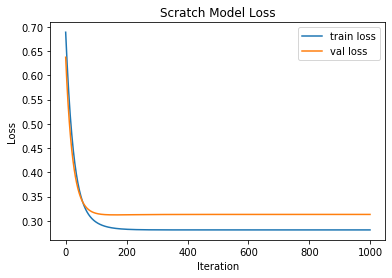

In [288]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure()

plt.plot(np.arange(len(scratch_logreg.loss)), scratch_logreg.loss, label='train loss')
plt.plot(np.arange(len(scratch_logreg.loss)), scratch_logreg.val_loss, label='val loss')
plt.title("Scratch Model Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()

## 【問題7】決定領域の可視化
決定領域を可視化してください。

>可視化にWeek4課題の決定領域関数を使用する。

In [115]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel',
                    ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

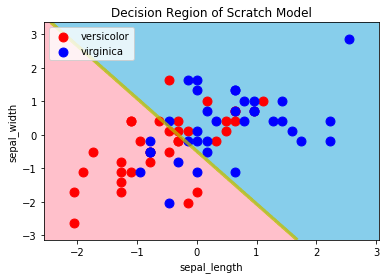

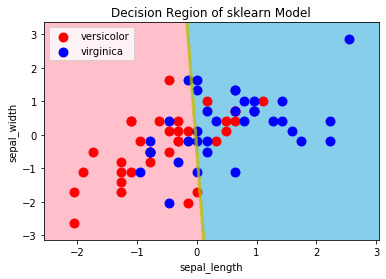

In [282]:
# sepal_lengthとsepal_widthを可視化
X_plot = X_train_std[:, :2]

scratch_plot = ScratchLogisticRegression()
scratch_plot.fit(X_plot, y_train)

sk_plot = LogisticRegression()
sk_plot.fit(X_plot, y_train)

decision_region(X_plot, y_train, scratch_plot, step=0.01, title='Decision Region of Scratch Model',
                xlabel='sepal_length', ylabel='sepal_width')
decision_region(X_plot, y_train, sk_plot, step=0.01, title='Decision Region of sklearn Model',
                xlabel='sepal_length', ylabel='sepal_width')

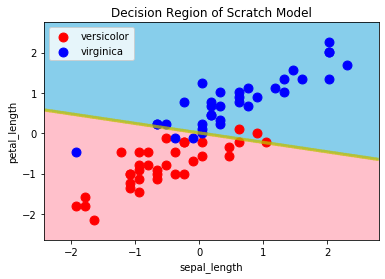

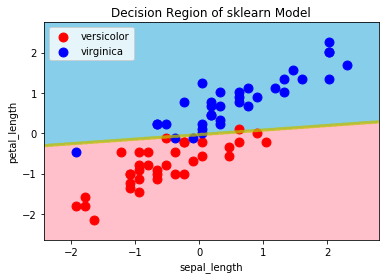

In [258]:
# sepal_lengthとpetal_lengthを可視化
X_plot = X_train_std[:, [0,2]]

scratch_plot = ScratchLogisticRegression()
scratch_plot.fit(X_plot, y_train)

sk_plot = LogisticRegression()
sk_plot.fit(X_plot, y_train)

decision_region(X_plot, y_train, scratch_plot, step=0.01, title='Decision Region of Scratch Model',
                xlabel='sepal_length', ylabel='petal_length')
decision_region(X_plot, y_train, sk_plot, step=0.01, title='Decision Region of sklearn Model',
                xlabel='sepal_length', ylabel='petal_length')

>二種類の特徴量の組み合わせを可視化したが、いずれもスクラッチモデルの推定はsklearnモデル同様に良好。上手く学習できたと思われる。

## 【問題8】（アドバンス課題）重みの保存
検証が容易になるように、学習した重みを保存および読み込みができるようにしましょう。pickleモジュールやNumPyのnp.savezを利用します。

In [137]:
import pickle

# パラメータをparams変数として保存
params = scratch_logreg.coef_

# pickle objectにparamsを保存
with open("params.pickle", "wb") as f:
    pickle.dump(params, f)
    
params

array([ 0.00406786,  0.07335182, -0.11095529,  0.74971909,  0.92481155])

In [138]:
# 保存されたpickle objectを新たな変数params_loadに代入
with open("params.pickle", "rb") as f:
    params_load = pickle.load(f)
    
params_load

array([ 0.00406786,  0.07335182, -0.11095529,  0.74971909,  0.92481155])

In [264]:
# 保存されたパラメータを使用して未学習のモデルで推定
logreg_pickle = ScratchLogisticRegression(coef=params_load, labels=np.array((1,2)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

scratch_pred = logreg_pickle.predict(X_test_std)

print("スクラッチモデルの成績")
print("-"*20)
print("正解率：{:.2f}".format(accuracy_score(y_test, scratch_pred)))
print("適合率：{:.2f}".format(precision_score(y_test, scratch_pred)))
print("再現率：{:.2f}".format(recall_score(y_test, scratch_pred)))
print("F1値：{:.2f}".format(f1_score(y_test, scratch_pred)))

スクラッチモデルの成績
--------------------
正解率：0.97
適合率：0.94
再現率：1.00
F1値：0.97
